## Avec Meta Graph

In [1]:
using AutoHashEquals

@auto_hash_equals struct NodeData
    presence_cpu::AbstractVector{Bool}
    presence_gpu::AbstractVector{Bool}
    mem_allocation_cpu::Float64
    mem_allocation_gpu::Float64
    state::Int64
    processor::String
end

@auto_hash_equals struct Cost
    cost_memory_transfer::Float64
    cost_computation::Float64
end

### Exemple tiré au hasard

In [3]:
n = 10; # taille des données
kmax = 3; # ordre max de complexité
I = 8; # nombre d'instructions
V = 8; # nombre de variables


ord_var  = rand(1:kmax, V);    # ordre de chaque variable (en taille) (entier)
var_need = rand(Bool, V, I);   # matrice booléenne des besoins de chaque variable au cours des étapes
var_fond = var_need[:,1];      # vecteur booléen   des variables fondatrices (chargées dans la mémoire CPU au début), qu'on utilise en premier
var_endn = rand(Bool, V)       # vecteur booléen   des variables de fin      (celles qui sont retournées par l'algorithme, dont on a besoin)
ord_op = rand(1:5, I, kmax+1); # nombre d'opérations d'ordre entre 0 et kmax par étape dans 1:I (normalement corrélée à VNeed mais ici exemple seulement)


### Exemples réels (vrai calcul)

In [981]:
# exemple calcul sur feuille ABC etc
n = 10; # taille des données
kmax = 3; # ordre max de complexité
I = 7; # nombre d'instructions
V = 7; # nombre de variables


ord_var = [2, 2, 2, 2, 1, 1, 1];
var_need = Bool[1 1 0 0 0 0 0; 0 0 1 1 0 0 0; 1 0 0 1 1 0 0; 0 1 1 0 0 0 0; 0 1 0 0 0 0 1; 1 0 1 0 0 0 0; 0 0 1 0 0 1 0];
var_fond = Vector(Bool[1, 1, 1, 1, 1, 1, 1]);
var_endn = Bool[1, 0, 1, 0, 1, 1, 1];
ord_op = [0 0 0 1; 0 0 0 1; 0 1 1 0; 0 0 0 1; 0 1 1 0; 0 0 0 1; 0 1 1 0];

In [24]:
# exemple calcul sur feuille ABu et v amoindri  etc
n = 10; # taille des données
kmax = 3; # ordre max de complexité
I = 3; # nombre d'instructions
V = 4; # nombre de variables


ord_var = [2, 2, 1, 1];
var_need = Bool[1 1 0 0; 1 0 1 1; 0 1 0 1; 0 0 1 1];
var_fond = Bool[1, 1, 1, 1];
var_endn = Bool[0, 0, 1, 1];
ord_op = [0 0 0 1; 0 1 1 0; 0 0 1 0];

In [25]:
hcat(var_need, var_endn)

4×5 Matrix{Bool}:
 1  1  0  0  0
 1  0  1  1  0
 0  1  0  1  1
 0  0  1  1  1

### Exemples reproductibles

In [676]:
# exemple reproductible 1
n = 10; # taille des données
kmax = 3; # ordre max de complexité
I = 6; # nombre d'instructions
V = 4; # nombre de variables


ord_var = [3, 1, 2, 2];
var_need = Bool[1 1 0 0 0 1; 1 1 0 0 0 0; 0 0 1 1 1 1; 0 1 1 1 1 0];
var_fond = Bool[1, 1, 0, 0];
var_endn = Bool[0, 1, 1, 0]
ord_op = [0 2 5 1; 3 5 5 1; 2 4 0 1; 1 1 0 1; 0 0 4 1; 1 1 3 4];

In [844]:
# exemple reproductible 2
n = 4; # taille des données
kmax = 3; # ordre max de complexité
I = 4; # nombre d'instructions
V = 5; # nombre de variables

ord_var = [2, 3, 1, 1, 1];
var_need = Bool[0 0 1 1; 0 0 1 1; 1 0 1 1; 0 1 1 1; 1 1 1 0];
var_fond = Bool[0, 0, 1, 0, 1];
var_endn = Bool[1, 1, 0, 1, 0];
ord_op = [1 2 0 4; 3 2 4 3; 1 4 1 4; 4 4 2 5];

### Coûts déduits des paramètres

In [26]:
# données déduites des paramètres
cost_op_gpu      = [max(1.0,float(n)^(k-1))      for k in 0:kmax]; # coût d'une opération d'ordre k sur gpu (plus rapide)
cost_op_cpu      = [float(n^k)          for k in 0:kmax]; # coût d'une opération d'ordre k sur cpu
cost_mem_var     = [float(n^ord_var[v]) for v in 1:V];    # place mémoire occupée par chaque variable (indépendant du processeur correspondant)

cst_tr_ord_var   = [float(5*n^k) for k in 0:kmax]; # coût de transfert d'une variable d'ordre k entre les mémoires
cost_trans_var   = [float(cst_tr_ord_var[ord_var[v]+1]) for v in 1:V]
cost_ins_gpu = ord_op*cost_op_gpu; # coût de chaque instruction sur GPU
cost_ins_cpu = ord_op*cost_op_cpu; # coût de chaque instruction sur CPU

mem_lim_gpu = 2000;

In [27]:
using MetaGraphsNext
# using MetaGraphs
using Graphs
using DataStructures
# https://juliagraphs.org/MetaGraphsNext.jl/dev/tutorial_basics/

# plusieurs nodes peuvent partager le même état (même avancement du computation_graph)
# chaque node a un identifiant unique qui est incrémenté dans la boucle
# à état égal, l'identifiant discrimine les valeurs en mémoire après les computation_graphs

# état: attribut non unique des nœuds, varie de 0 à I+1 (0: départ, I+1: arrivée, ne correspondent pas à des calculs, et i∈⟦1,I⟧ correspondent à I instructions au total)
# identifiant: attribut unique des nœuds

# CRÉATION DU GRAPHE
minimum_weight = 0.0
default_weight = Inf64;
computation_graph = MetaGraph(DiGraph(),
                                VertexData = NodeData,
                                EdgeData = Cost,
                                graph_data = "pathway",
                                weight_function = (x::Cost -> x.cost_computation + x.cost_memory_transfer),
                                default_weight=default_weight)

# CRÉATION DU DICTIONNAIRE ET DE LA QUEUE LIFO (parcours en largeur)
queue_nodes = Queue{Int64}();

dict_ident  = Dict{UInt64, Int64}(); # hash, indice


# AJOUT DU NŒUD DE DÉPART
initial_state = 0;
nd_id_initial = 0;
add_vertex!(computation_graph,
                    Symbol(nd_id_initial),
                    NodeData(var_need[:,1], zeros(Bool, V), var_fond'*cost_mem_var, 0.0, initial_state, "InitialState"))
dict_ident[hash(computation_graph[Symbol(nd_id_initial)])] = nd_id_initial; # ajout du hash du nœud initial au dictionnaire des identifiants

# AJOUT DU NŒUD D'ARRIVÉE
final_state = I+1;
nd_id_final = -1
add_vertex!(computation_graph,
                    Symbol(nd_id_final),
                    NodeData(var_endn,      zeros(Bool, V), var_endn'*cost_mem_var, 0.0, final_state, "FinalState"))
dict_ident[hash(computation_graph[Symbol(nd_id_final)])] = nd_id_final; # ajout du hash du nœud au dictionnaire des identifiants


In [28]:
dict_ident

Dict{UInt64, Int64} with 2 entries:
  0xe2b2c1a92559a9a9 => -1
  0x3cb5e7cea96adc46 => 0

In [29]:
function display_graph_chars(graph)
    @show Graphs.is_directed(graph);
    @show Graphs.eltype(graph);
    @show Graphs.edgetype(graph);
    # @show label_for(graph, 1);
    @show Graphs.nv(graph); # nombre de vertex (sommets)
    @show Graphs.ne(graph); # nombre d'edges orientés (arêtes)
    @show weighttype(graph);
    return nothing
end

display_graph_chars(computation_graph)

Graphs.is_directed(graph) = true
Graphs.eltype(graph) = Int64
Graphs.edgetype(graph) = Graphs.SimpleGraphs.SimpleEdge{Int64}
Graphs.nv(graph) = 2
Graphs.ne(graph) = 0
weighttype(graph) = Float64


In [30]:
function proposition_path_gpu_acc(pr_c, pr_g, m_a_c, m_a_g, ste, next_var_nec, or_and_p_v_n) # acc pour accumulate (accumuler les variables d'abord)
    var_import_gpu    = (next_var_nec .& .~pr_g);
    cost_trans        = var_import_gpu'*cost_trans_var # coût d'importer les (var nécessaires ET pas déjà présentes sur le GPU) sur GPU
    cost_calc         = cost_ins_gpu[ste+1];
    pr_g_new          = (next_var_nec .|   pr_g)    .& or_and_p_v_n;
    pr_c_new          = (pr_c .& .~ var_import_gpu) .& or_and_p_v_n;
    # @assert pr_g_new >= next_var_nec;
    return cost_trans, cost_calc, pr_g_new, pr_c_new
end

function proposition_path_gpu_emp(pr_c, pr_g, m_a_c, m_a_g, ste, next_var_nec, or_and_p_v_n) # emp pour empty (vider les variables d'abord)
    var_import_export = xor.(next_var_nec, pr_g);
    cost_trans        = var_import_export'*cost_trans_var # coût d'importer les (var nécessaires ET pas déjà présentes sur le GPU) sur GPU et rapatrier les variables non utilisées sur le CPU pour faire de la place (fait en premier)
    cost_calc         = cost_ins_gpu[ste+1];
    pr_g_new          = next_var_nec                        .& or_and_p_v_n;
    pr_c_new          = (pr_c .| (.~next_var_nec .&  pr_g)) .& or_and_p_v_n;
    # @assert pr_g_new >= next_var_nec;
    return cost_trans, cost_calc, pr_g_new, pr_c_new
end

function proposition_path_cpu(pr_c, pr_g, m_a_c, m_a_g, ste, next_var_nec, or_and_p_v_n)
    var_import_gpu    = next_var_nec .& pr_g;          # variables qu'on importe sur le CPU depuis le GPU avant calcul
    cost_trans        = var_import_gpu'*cost_trans_var # coût d'importer les (var nécessaires ET présentes sur GPU) sur le CPU
    cost_calc         = cost_ins_cpu[ste+1];
    pr_g_new          = (pr_g .& .~var_import_gpu) .& or_and_p_v_n;
    pr_c_new          = (pr_c .|   var_import_gpu) .& or_and_p_v_n;
    # @assert pr_c_new >= next_var_nec;
    return cost_trans, cost_calc, pr_g_new, pr_c_new
end

proposition_path_cpu (generic function with 1 method)

In [31]:
function màj_graphe_calcul(nd_id_proc, queue_nodes, nd_id_iter, cost_trans, cost_calc, pr_g_new, pr_c_new, ste, processor_str) # ste représente ici l'état du node sur lequel on se place duquel on crée les fils
    # println("** calling màj graph, source of id=$nd_id_proc, ste=$ste")
    # println("queue_nodes=$queue_nodes")
    m_al_cpu_new    = pr_c_new'*cost_mem_var; # CPU: calcul de l'occupation mémoire dans l'état après calcul
    m_al_gpu_new    = pr_g_new'*cost_mem_var; # GPU: calcul de l'occupation mémoire dans l'état après calcul
    
    new_child_node      = NodeData(pr_c_new, pr_g_new, m_al_cpu_new, m_al_gpu_new, ste+1, processor_str);
    new_child_node_hash = hash(new_child_node);
    if ~haskey(dict_ident, new_child_node_hash);          # si node existe PAS dans le dictionnaire
        nd_id_next = nd_id_iter + 1;                      # identifiant: on prend comme identifiant l'identifiant du node courant + 1
        
        dict_ident[new_child_node_hash] = nd_id_next;     # on ajoute (hash,identifiant) de ce node au dico des nodes
        add_vertex!(computation_graph, Symbol(nd_id_next), new_child_node);  # on crée    le nouveau node dans le graphe
        enqueue!(queue_nodes, nd_id_next);                # on enfile l'ident du nouveau node dans la queue # computation_graph[Symbol(nd_id_next)]
        computation_graph[Symbol(nd_id_proc), Symbol(nd_id_next)] = Cost(cost_trans, cost_calc); # on ajoute le poids de l'arête
                           
        # println("creating new node of id=$nd_id_next, ste=$(ste+1) on "*processor_str*"")
        # println(new_child_node)
        # println("adding weight $nd_id_proc -> $nd_id_next on "*processor_str)
        new_nd_id_iter = nd_id_iter + 1;  # on incrémente l'identifiant
    else                                     # si le node existe DÉJÀ dans le dictionnaire
        nd_id_next = get(dict_ident, new_child_node_hash, nothing); # identifiant: on récupère son identifiant dans le dico des identifiants
                                             # pas besoin de l'enfiler car ça a déjà été le cas, et a déjà été ou sera traité
                                             # puisqu'on parcours en largeur, il doit y être encore
        computation_graph[Symbol(nd_id_proc), Symbol(nd_id_next)] = Cost(cost_trans, cost_calc); # on ajoute le poids de l'arête
        # println("using already existing node of id=$nd_id_next")
        # println("adding weight $nd_id_proc -> $nd_id_next")
        new_nd_id_iter = nd_id_iter;
    end
    
    # println("end call màj graph")
    # println("queue_nodes=$queue_nodes\n\n")
    return new_nd_id_iter
end

màj_graphe_calcul (generic function with 1 method)

## Boucle While

In [32]:
nd_id_iter = initial_state; # à ce stade seuls 0 et -1 sont attribués comme identifiants; on remplit dans ℕ.
                            # nd_id_iter va être itéré au fur et à mesure des ajouts de nouveaux nœuds
                            # la variable est absolument décorrélée de la boucle while ci-dessous
                            # à chaque nouvel ajout, on incrémente

enqueue!(queue_nodes, nd_id_iter); # ajout dans la queue du premier nœud pour initier la récurrence


while (~isempty(queue_nodes))
    node_proc = computation_graph[Symbol(dequeue!(queue_nodes))] # node à traiter (to be processed)
    # extraction des données caractérisant l'état du nœud
    pr_c  = node_proc.presence_cpu;
    pr_g  = node_proc.presence_gpu;
    m_a_c = node_proc.mem_allocation_cpu;
    m_a_g = node_proc.mem_allocation_gpu;
    ste   = node_proc.state;

    nd_id_proc = dict_ident[hash(node_proc)];
                                    
    #disjonction de cas: est-ce que le nœud qu'on traite en ce moment représente la fin du dernier calcul (instruction I) ??
    if ste < I # si on n'est pas arrivé au bout du calcul
        next_var_nec = var_need[:,ste+1];    # variables nécessaires à l'étape  directement suivante     au  noeud traité (i.e. nécessaires pour les nœuds fils)
        post_var_nec = var_need[:,ste+2:I]   # variables nécessaires aux étapes strictement postérieures aux nœuds fils   (pour virer les variables qui ne sont plus utilisées ensuite)
        or_and_p_v_n = Array{Bool}(!=(0).(hcat(post_var_nec,var_endn)[:,1:I-ste]*ones(Bool,I-ste)))
        
        
        if (next_var_nec .|  pr_g)'*cost_mem_var ≤ mem_lim_gpu
            cost_trans, cost_calc, pr_g_new, pr_c_new = proposition_path_gpu_acc(pr_c, pr_g, m_a_c, m_a_g, ste, next_var_nec, or_and_p_v_n);
            nd_id_iter = màj_graphe_calcul(nd_id_proc, queue_nodes, nd_id_iter, cost_trans, cost_calc, pr_g_new, pr_c_new, ste, "GPU");
    
        elseif next_var_nec'*cost_mem_var        ≤ mem_lim_gpu
            cost_trans, cost_calc, pr_g_new, pr_c_new = proposition_path_gpu_emp(pr_c, pr_g, m_a_c, m_a_g, ste, next_var_nec, or_and_p_v_n);
            nd_id_iter = màj_graphe_calcul(nd_id_proc, queue_nodes, nd_id_iter, cost_trans, cost_calc, pr_g_new, pr_c_new, ste, "GPU");
        else
            nothing
        end
        
        if true # par symétrie du code; on peut choisir de désactiver ce choix
            cost_trans, cost_calc, pr_g_new, pr_c_new = proposition_path_cpu(pr_c, pr_g, m_a_c, m_a_g, ste, next_var_nec, or_and_p_v_n);
            nd_id_iter = màj_graphe_calcul(nd_id_proc, queue_nodes, nd_id_iter, cost_trans, cost_calc, pr_g_new, pr_c_new, ste, "CPU");
        end

        
    elseif ste >= I # si on est arrivé au bout du calcul
        cost_calc = minimum_weight;
        cost_trans = (var_endn .& pr_g)'*cost_trans_var; # coût d'importer les (var utiles à la fin ET présentes sur GPU) sur le CPU à nouveau
        nd_id_current = get(dict_ident, hash(node_proc), nothing);
        computation_graph[Symbol(nd_id_current), Symbol(nd_id_final)] = Cost(cost_trans, cost_calc); # créer l'arête entre ce nœud et le nœud de fin avec le coût de transfert seulement
    end
end

In [33]:
display_graph_chars(computation_graph)

Graphs.is_directed(graph) = true
Graphs.eltype(graph) = Int64
Graphs.edgetype(graph) = Graphs.SimpleGraphs.SimpleEdge{Int64}
Graphs.nv(graph) = 12
Graphs.ne(graph) = 18
weighttype(graph) = Float64


## Pour plotter le graphe

In [34]:
function coloration(i)
    n = computation_graph[Symbol(i)];
    if n.processor == "InitialState"
        return 1
    elseif n.processor == "FinalState"
        return 2
    elseif n.processor == "GPU"
        return 3
    elseif n.processor == "CPU"
        return 4
    else
        return 5
    end
end

function nom_label(i)
    n = computation_graph[Symbol(i)];
    return code_for(computation_graph, Symbol(i)), n.state #  numéro du node, identifiant: get(dict_ident, hash(n), nothing), état
end

nom_label (generic function with 1 method)

In [35]:
# https://juliagraphs.org/MetaGraphs.jl/dev/ pour les codes entre indices faits par symboles et les indices codés automatiquement par julia (pour interpréter les rendus de Dijkstra)
code_for(computation_graph, Symbol(0)), label_for(computation_graph, 1)

(1, Symbol("0"))

In [36]:
using Graphs
using GraphPlot
using Compose
using Cairo, Fontconfig
using Colors

# créer les labels des nœuds
nodenums = vcat([0],[-1],1:Graphs.nv(computation_graph)-2)

nodelabels = nom_label.(label for label in nodenums);

# créer les labels des arêtes
using SparseArrays
weight_matrix = Matrix(Graphs.weights(computation_graph))
weights_vector = Vector(reshape(transpose(weight_matrix), Graphs.nv(computation_graph)^2));
edgelabels = deleteat!(weights_vector, findall(x->x==Inf, weights_vector));


# couleur des nœuds en fonction du label
membership = coloration.(i for i in nodenums)
couleurs = [colorant"seagreen2",  colorant"darkgoldenrod2",  colorant"coral2", colorant"steelblue2", colorant"green1"]


nodecolors = couleurs[membership];

# taille des nœuds
nodesizes = 3*ones(Int64, Graphs.nv(computation_graph)); # [Graphs.outdegree(computation_graph, v) for v in Graphs.vertices(computation_graph)];

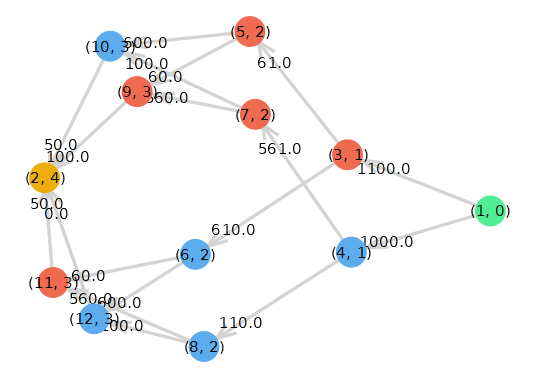

In [38]:
G = gplot(computation_graph, nodelabel=nodelabels, nodefillc=nodecolors, nodesize=10, edgelabel=edgelabels, layout=spring_layout) # nodesize=nodesizes # 
draw(PNG("./graph_computation.png", 20cm, 20cm), G); # , layout= spring_layout spectral_layout
G

In [1027]:
vertices(computation_graph)
weights(computation_graph)

MetaWeights of size (49, 49)

In [1028]:
Graphs.nv(computation_graph)

49

In [648]:
getindex(computation_graph, Symbol(3))

NodeData(Bool[0, 0, 0, 0, 0, 0, 0, 0], Bool[1, 1, 1, 0, 1, 1, 1, 1], 0.0, 3310.0, 2, "GPU")

In [729]:
display_graph_chars(computation_graph)

Graphs.is_directed(graph) = true
Graphs.eltype(graph) = Int64
Graphs.edgetype(graph) = Graphs.SimpleGraphs.SimpleEdge{Int64}
Graphs.nv(graph) = 9
Graphs.ne(graph) = 10
weighttype(graph) = Float64


In [730]:
# https://juliagraphs.org/Graphs.jl/dev/algorithms/shortestpaths/#Graphs.dijkstra_shortest_paths-Union{Tuple{T},%20Tuple{U},%20Tuple{AbstractGraph,%20Vector{U}},%20Tuple{AbstractGraph,%20Vector{U},%20AbstractMatrix{T}}}%20where%20{U%3C:Integer,%20T%3C:Real}
# https://discourse.julialang.org/t/dijkstra-state/20124 pour comprendre les attributs

ds = Graphs.dijkstra_shortest_paths(computation_graph,
                                    code_for(computation_graph, Symbol(0)),
                                    allpaths=false,
                                    trackvertices=true)

Graphs.DijkstraState{Float64, Int64}([0, 8, 1, 1, 3, 4, 5, 7, 7], [0.0, 4753.400000000001, 4.6, 41.0, 145.6, 182.0, 4478.1, 4753.400000000001, 6731.1], [Int64[], Int64[], Int64[], Int64[], Int64[], Int64[], Int64[], Int64[], Int64[]], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1, 3, 4, 5, 6, 7, 8, 2, 9])

In [651]:
ds.parents[5]

3